# Laboratory #07 : Image Classification using Bag of Visual Words

At the end of this laboratory, you would get familiarized with

*   Creating Bag of Visual Words
    *   Feature Extraction
    *   Codebook construction
    *   Classification
*   Using pre-trained deep networks for feature extraction

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Use will have to mount your drive if you need to access images.

---

In [1]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)

import os
import numpy as np

from skimage.feature import ORB
from skimage.color import rgb2gray
from skimage.io import imread
from skimage.exposure import histogram

from matplotlib import pyplot as plt

## Loading dataset

We will use 3 categories from Caltech 101 objects dataset for this experiment. Upload the dataset to the drive and mount it.

In [2]:
# creating the list of files and corresponding labels

data = []
labels = []

categories = ['butterfly', 'kangaroo', 'dalmatian']

for idx, cat in enumerate(categories):
    files_list = os.listdir(cat)
    for filename in files_list:
        data.append(os.path.join(cat, filename))
        labels.append(idx)

labels = np.array(labels)

print('Total number of images:', len(data))

Total number of images: 244


In [3]:
ncl = len(categories) * 10

In [4]:
# creating train test split

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print('Train set:', len(x_train))
print('Test set:', len(x_test))

Train set: 195
Test set: 49


## Feature Extraction using ORB

The first step is to extract descriptors for each image in our dataset. We will use ORB to extract descriptors.

*   Create ORB detector with 64 keypoints.


In [5]:
# solution
orbDetector = ORB(n_keypoints=64)

*   Extract ORB descriptors from all the images in the train set.
*   Note that, each patch would produce a descriptor of size (256,). So each image would return (N x 256) descriptors, where N is the number of keypoints.

In [6]:
# solution
def get_descriptors(data):
    descriptors = list()
    for img_path in data:
        img = imread(img_path, as_gray=True)
        orbDetector.detect_and_extract(img)
        descriptors.append(orbDetector.descriptors)
    return np.array(descriptors)

In [7]:
# solution
train_descriptors = get_descriptors(x_train)
print("number of images: ", train_descriptors.shape[0])
print("shape of features extracted: ", train_descriptors.shape[1:])
print("descriptors shape: ", train_descriptors.shape)

number of images:  195
shape of features extracted:  (64, 256)
descriptors shape:  (195, 64, 256)


## Codebook Construction

Codewords are nothing but vector representation of similar patches. This codeword produces a codebook similar to a word dictionary. We will create the codebook using K-Means algorithm

*   Create a codebook using K-Means with k=number_of_classes*10
*   Hint: Use sklearn.cluster.MiniBatchKMeans for K-Means

In [8]:
from sklearn.cluster import MiniBatchKMeans

In [9]:
# solution
kmeans = MiniBatchKMeans(n_clusters=ncl)

In [10]:
# solution
all_descriptors = np.reshape(train_descriptors, (-1, 256))
y_pred = kmeans.fit_predict(all_descriptors)

*   Create a histogram using the cluster centers for each image descriptor.
    *   Remember the histogram would be of size *n_images x n_clusters*.
    *   Calculate the histogram and divide by the feature length to normalize

In [11]:
# solution
def create_histogram(data):
    histograms = np.empty((len(data), kmeans.n_clusters))
    for idx, descriptors in enumerate(data):
        hist, _ = np.histogram(descriptors, bins=kmeans.n_clusters)
        hist = hist / descriptors.shape[0]
        histograms[idx] = hist
    return histograms

In [12]:
image_labels = np.reshape(y_pred, (-1, 64))
print("image_labels.shape: ", image_labels.shape)

dictionary = create_histogram(image_labels)
print("dictionary.shape: ", dictionary.shape)

image_labels.shape:  (195, 64)
dictionary.shape:  (195, 30)



# Creating Classification Model

*   The next step is to create a classification model. We will use a C-Support Vector Classification for creating the model.



In [13]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [14]:
# note the usage of grid search to select the best parameters

gammas = np.logspace(-6, -1, 10)
C = np.array([0.5, 1, 2, 4, 8, 10, 15, 20, 50, 100, 200, 375, 500, 1000])

svc = SVC(decision_function_shape='ovr')

clf = GridSearchCV(estimator=svc, param_grid=dict(gamma=gammas, C=C), n_jobs=-1)

clf.fit(dictionary,y_train)

print('Best accuracy:', clf.best_score_) 
print('The best value of gamma:', clf.best_estimator_.gamma)
print('The best value of C:', clf.best_estimator_.C)

Best accuracy: 0.49230769230769234
The best value of gamma: 0.1
The best value of C: 200.0


# Testing the Classification Model

*   Extract descriptors using ORB for the test split
*   Use the previously trained k-means to generate the histogram
*   Use the classifier to predict the label


In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [16]:
# Extract and reshape ORB descriptors
test_descriptors = get_descriptors(x_test)
all_descriptors = np.reshape(test_descriptors, (-1, 256))
print("all_descriptors.shape: ", all_descriptors.shape)

all_descriptors.shape:  (3136, 256)


In [17]:
# Predict clusters for each descriptor
y_pred = kmeans.predict(all_descriptors)
print("y_pred: ", y_pred.shape)

y_pred:  (3136,)


In [18]:
# Reshape to n_images x m_keypoints
image_labels = np.reshape(y_pred, (-1, 64))
print("image_labels.shape: ", image_labels.shape)

image_labels.shape:  (49, 64)


In [19]:
# Generate the histogram
dictionary = create_histogram(image_labels)
print("dictionary.shape: ", dictionary.shape)

dictionary.shape:  (49, 30)


In [20]:
# Call the classifier to predict the label
prediction = clf.predict(dictionary)
print("prediction.shape: ", prediction.shape)

prediction.shape:  (49,)


*   Calculate the accuracy score for the classification model

In [21]:
print(confusion_matrix(y_test, prediction))
print("Accuracy score for the classification model: ", 100*accuracy_score(y_test, prediction))

[[13  6  0]
 [ 8  7  3]
 [ 3  3  6]]
Accuracy score for the classification model:  53.06122448979592


*   Why do we use Clustering to create the codebook? 
*   What are the other techniques that can be used to create the codebook?

**Solution**

- Once we've obtained the local patches (feature descriptors), we need to convert them into the codewords that will compose the codebook. As a codeword can be considered as a prototype or representative of several similar patches, we can cluster them in order to obtain the centers of the learned clusters and assign its indexes as codewords.

  Thus, each patch in an image is mapped to a certain codeword through the clustering process and the image can be represented by the histogram of the codewords.  

- There are two ways to generate a codebook: supervised and unsupervised. In both methods of generation, the feature descriptors, i.e. visual words, are classified into several classes. Supervised codebook generation involves only clustering together feature descriptors, i.e. visual words, in the same class while unsupervised codebook generation clusters together feature descriptors, i.e. visual words, of any class and classifies the clusters based on the dominant class.

  There are many techniques available for generating the codebook. The most widely used Generalized Lloyd Algorithm (GLA) starts with an initial solution, which is iteratively improved using two optimality criteria in turn until a local minimum is reached. A codebook can also be built hierarchically with the iterative splitting algorithm that starts with a codebook of size one, which is the centroid of the entire training set. The codebook is then iteratively enlarged by a splitting procedure until it reaches the desired size. An other hierarchical algorithm, the Pairwise Nearest Neighbor (PNN), uses an opposite bottom up approach to generate the codebook.

An explanation of other methods for the generation of codebooks are explained in this [Link](https://www.researchgate.net/publication/252015622_Techniques_for_generating_initial_codebook_for_Vector_Quantization)



# Extracting features from Deep Network

It is quite possible to extract features (similar to SIFT or ORB) from different layers of deep network.

*   Load ResNet50 model with imagenet weights and check the summary of the model
*   Create a model to extract features from the 'avg_pool' layer.
*   Extract features from the layer for all the train images.

In [22]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model

In [23]:
base_model = ResNet50(weights='imagenet')
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [24]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer('conv5_block3_3_conv').output)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [25]:
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing import image

def load_images(images_paths):
    images = np.empty((len(images_paths), 224, 224, 3))
    for idx, img_path in enumerate(images_paths):
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        images[idx] = x
    return images

images = load_images(x_train)
images = preprocess_input(images)
feature_descriptors = model.predict(images)
print("feature_descriptors.shape: ", feature_descriptors.shape)

feature_descriptors.shape:  (195, 7, 7, 2048)


*   Create codebook using the extracted features

In [26]:
all_descriptors = np.reshape(feature_descriptors, (-1, 2048))
print("all_descriptors.shape: ", all_descriptors.shape)

all_descriptors.shape:  (9555, 2048)


In [27]:
kmeans = MiniBatchKMeans(n_clusters=ncl)

# Predict clusters for each descriptor
y_pred = kmeans.fit_predict(all_descriptors)
print("y_pred.shape: ", y_pred.shape)

y_pred.shape:  (9555,)


In [28]:
# Reshape to n_images x m_keypoints
image_labels = np.reshape(y_pred, (-1, 49))
print("image_labels.shape: ", image_labels.shape)

image_labels.shape:  (195, 49)


In [29]:
# Generate the histogram
dictionary = create_histogram(image_labels)
dictionary.shape

(195, 30)

*   Train SVM classifier using the codebook

In [30]:
gammas = np.logspace(-6, -1, 10)
C = np.array([0.5, 1, 2, 4, 8, 10, 15, 20, 50, 100, 200, 375, 500, 1000])

svc = SVC(decision_function_shape='ovr')

clf = GridSearchCV(estimator=svc, param_grid=dict(gamma=gammas, C=C), n_jobs=-1)

clf.fit(dictionary, y_train)

print('Best accuracy:', clf.best_score_) 
print('The best value of gamma:', clf.best_estimator_.gamma)
print('The best value of C:', clf.best_estimator_.C)

Best accuracy: 0.953846153846154
The best value of gamma: 0.007742636826811277
The best value of C: 1000.0


*   Evaluate the test set using the above method

In [31]:
images = load_images(x_test)
images = preprocess_input(images)
test_feature_descriptors = model.predict(preprocess_input(images))
print("test_feature_descriptors.shape: ", test_feature_descriptors.shape)

test_feature_descriptors.shape:  (49, 7, 7, 2048)


In [32]:
all_descriptors = np.reshape(test_feature_descriptors, (-1, 2048))
print("all_descriptors.shape: ",all_descriptors.shape)

all_descriptors.shape:  (2401, 2048)


In [33]:
# Predict clusters for each descriptor
y_pred = kmeans.predict(all_descriptors)
print("y_pred.shape: ",y_pred.shape)

y_pred.shape:  (2401,)


In [34]:
# Reshape to n_images x m_keypoints
image_labels = np.reshape(y_pred, (-1, 49))
print("image_labels.shape: ",image_labels.shape)

image_labels.shape:  (49, 49)


In [35]:
# Generate the histogram
dictionary2 = create_histogram(image_labels)
print("dictionary2.shape: ",dictionary2.shape)

dictionary2.shape:  (49, 30)


In [36]:
# Call the classifier to predict the label
prediction = clf.predict(dictionary2)
print("prediction.shape: ",prediction.shape)

prediction.shape:  (49,)


*   Calculate the accuracy score for the classification model

In [41]:
print(confusion_matrix(y_test, prediction))
print("Accuracy score for the classification model: {0:.2f}%".format(100*accuracy_score(y_test, prediction)))

[[16  2  1]
 [ 0 17  1]
 [ 0  0 12]]
Accuracy score for the classification model: 91.84%


## t-distributed Stochastic Neighbor Embedding.

In order to visualize the features of a higher dimension data, t-SNE is used. t-SNE converts the affinities of the data points to probabilities. It recreates the probability distribution in a low-dimensional space. It is very helpful in visualizing features of different layers in a neural network.

You can find more information about t-SNE [here](https://scikit-learn.org/stable/modules/manifold.html#t-distributed-stochastic-neighbor-embedding-t-sne)

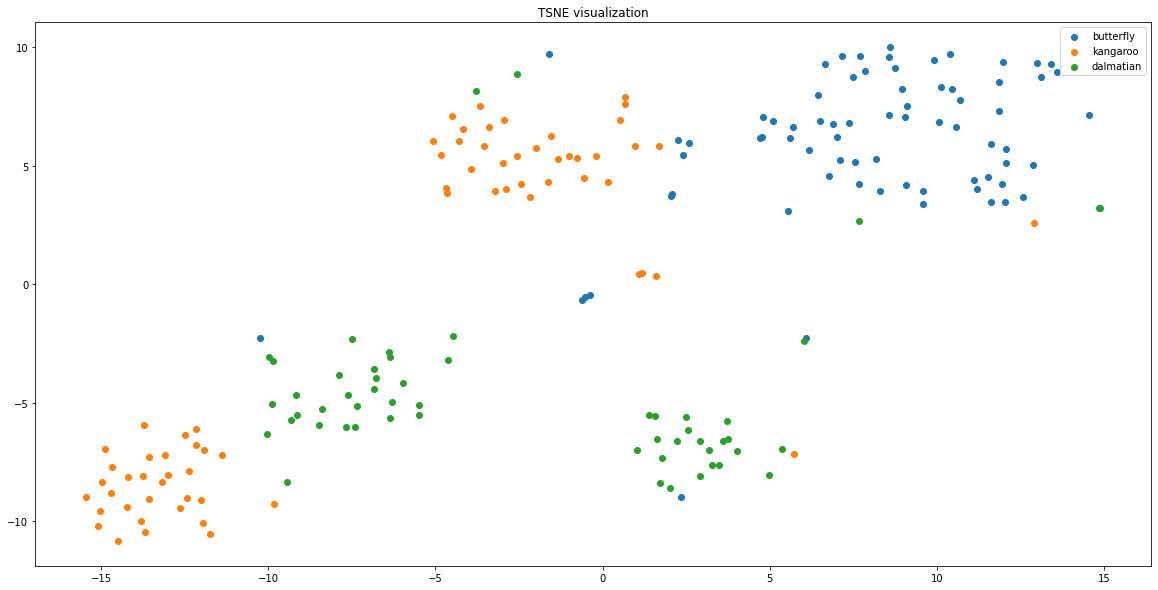

In [51]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0)

np.set_printoptions(suppress=True)

low_embedding = model.fit_transform(dictionary) 

plt.figure(figsize=(20,10))
for cat, label in zip(categories, np.unique(y_train)):
    subData = low_embedding[y_train == label]
    plt.scatter(subData[:, 0], subData[:, 1], label=cat)
plt.title("TSNE visualization")
plt.legend()
plt.show()

*   What do you infer from the t-SNE plot?

**Solution**

Butterfly class is pretty "independent" while the other two have overlappings. That means that the codewords for the feature descriptors of the images of the last two classes are similar. However, the test set only consists of 49 instances it is difficult to generalize to the whole domain with this small of a metric.

*   Compare the performance of both the BoVW models. Which model works better and why?

The second BoVW model, which we use a subset of the ResNet model to obtain the feature descriptors works quite better. This is due to the fact that this is a deep model trained to extract features on large corpora in contrast with ORB. Additionaly, the ResNet descriptors have 4 times the dimesions of the ORB extracted vectors. That could be helping the model to capture more variability in the meaningful descriptors. Also, the ResNet is not a deterministic model unlike ORB. ORB is based on heuristics thought to generalize to all images, however, the ResNet arquitecture is a statistical model specifically trained to perform object recognition and classification tasks and as such it is capable to extract features very specific to the object classification task.

Inspecting the classes for which the imagenet weights in the ResNet arquitecture were trained [http://image-net.org/explore], we can see that within the output classes reside animal_invertebrate_arthropod_insect_lepidopterous_butterfy, animal_domestic_dog and animal_chordate_vertebrate_mammal_metatherian_marsupial_kangaroo. This may very well explain why the model performs so well in extracting the features for the images.  

*   Can the performance of pre-trained model increased further? If so, how?

Yes, for example we can do a process of fine-tuning on our own training data in order to fit a pre-trained model into a specific domain. This can be done by slightly tweaking the weights of the whole network or, it can be done by annexing a different output classification layer with only the three classes to detect (transfer learning) and just training this section of the network while freezing the weights of the rest of the layers.


---

## **End of P7: Image Classification using Bag of Visual Words**
Deadline for P7 submission in CampusVirtual is: **Thursday, the 26th of November, 2020**